In [1]:
import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.approximation import steiner_tree

In [2]:
COST_VIA = 4
COST_MH = 2
COST_MV = 2

def create_routing_grid(num_tracks_x=4, num_tracks_y=4):

    # Edge weights
    w_via = COST_VIA
    w_mh = COST_MH
    w_mv = COST_MV

    G = nx.Graph()

    # Define nodes
    for layer in ['mh', 'mv']:
        for y in range(num_tracks_y):
            nodes = [f'{layer}_{x}_{y}' for x in range(num_tracks_x)]        
            color = '#b0c24a' if layer == 'mh' else '#dda0dd'
            G.add_nodes_from(nodes, color=color)

    # Define edges
    edges = [(f'mh_{x}_{y}', f'mh_{x+1}_{y}') for x in range(num_tracks_x-1) for y in range(num_tracks_y)]
    G.add_edges_from(edges, weight=w_mh, color='black')

    edges = [(f'mv_{x}_{y}', f'mv_{x}_{y+1}') for x in range(num_tracks_x) for y in range(num_tracks_y-1)]
    G.add_edges_from(edges, weight=w_mv, color='black')

    edges = [(f'mh_{x}_{y}', f'mv_{x}_{y}') for x in range(num_tracks_x) for y in range(num_tracks_y)]
    G.add_edges_from(edges, weight=w_via, color='black')

    return G


def draw_grid(G, title=None):

    offset = {'mh': 0, 'mv': 0.25}
    positions = dict()
    for node in G:
        layer, x, y = node.split('_')
        o = offset[layer]
        positions[node] = (int(x)+o, int(y)+o)

    node_colors = nx.get_node_attributes(G, 'color')
    node_color = [node_colors[node] for node in G.nodes()]

    edge_colors = nx.get_edge_attributes(G, 'color')
    edge_color = [edge_colors[edge] for edge in G.edges()]

    edge_weights = nx.get_edge_attributes(G, 'weight')
    width = [max(edge_weights[edge], 1) for edge in G.edges()]

    fig_size = int(np.sqrt(len(G)))//2 + 1
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    nx.draw(G, ax=ax, with_labels=False, font_size=6, node_size = 50,
            pos=positions,
            node_color=node_color,
            edge_color=edge_color,
            width=width)
    if title:
        ax.set_title(title)


def create_pins_on_grid(G, pins):
    edge_attributes = dict()
    node_attributes = dict()
    terminal_nodes = list()
    for pin in pins:
        if len(pin) == 5:  # metal
            layer, x0, y0, x1, y1 = pin
            assert (x0 == x1 and y0 < y1) or (x0 < x1 and y0 ==  y1), f'Illegal pin {pin}'

            node_pairs = list()
            if x0 == x1:  # vertical
                node_pairs = [ (f'{layer}_{x0}_{i}', f'{layer}_{x0}_{i+1}') for i in range(y0, y1) ]
            else:  # horizontal
                node_pairs = [ (f'{layer}_{i}_{y0}', f'{layer}_{i+1}_{y0}') for i in range(x0, x1) ]

            for node0, node1 in node_pairs:
                edge_attributes[(node0, node1)] = {'weight': 0, 'color': 'red'}
                node_attributes[node0] = 'red'
                node_attributes[node1] = 'red'
                terminal_nodes.append(node0)
                terminal_nodes.append(node1)

        elif len(pin) == 4:  # via
            layer1, layer2, x0, y0 = pin
            key = (f'{layer1}_{x0}_{y0}', f'{layer2}_{x0}_{y0}')
            edge_attributes[key] = {'weight': 0}
        else:
            assert False, f'Illegal pin definiton {pin}'

    nx.set_edge_attributes(G, edge_attributes)
    nx.set_node_attributes(G, node_attributes, 'color')
    return set(terminal_nodes)


def steiner_tree_wrapper(G, terminal_nodes, update_graph=True):
    s = time.time()
    Gst = steiner_tree(G, terminal_nodes, method='mehlhorn', weight='weight')
    e = time.time()
    print(f'Runtime: {e-s:.3f} seconds')

    w = nx.get_edge_attributes(Gst, 'weight')
    cost = sum(w.values())

    if update_graph:
        node_attributes = {node: 'red' for node in Gst.nodes()}
        nx.set_node_attributes(G, node_attributes, 'color')
        edge_attributes = {edge: 'red' for edge in Gst.edges()}
        nx.set_edge_attributes(G, edge_attributes, 'color')
        edge_attributes = {edge: 4 for edge in Gst.edges()}
        nx.set_edge_attributes(G, edge_attributes, 'weight')

    return Gst, cost

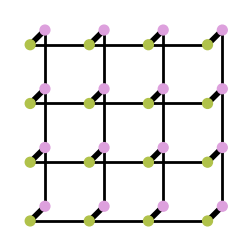

In [3]:
# Example routing grid
G = create_routing_grid(num_tracks_x=4, num_tracks_y=4)
draw_grid(G)

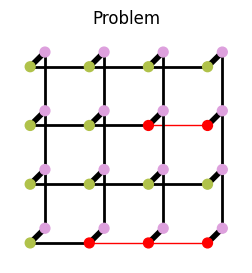

In [4]:
# Create routing problem
G = create_routing_grid(num_tracks_x=4, num_tracks_y=4)
pins = [
    ('mh', 1, 0, 3, 0),
    ('mh', 2, 2, 3, 2)
]
terminal_nodes = create_pins_on_grid(G, pins)
draw_grid(G, title='Problem')
w = nx.get_edge_attributes(G, 'weight')
assert w[('mh_1_0', 'mh_2_0')] == 0
assert w[('mh_2_0', 'mh_3_0')] == 0

Runtime: 0.003 seconds


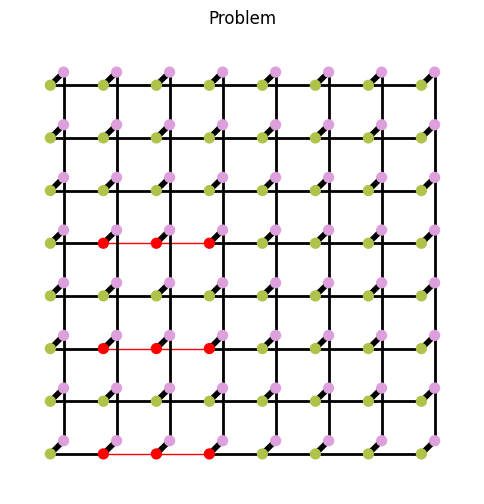

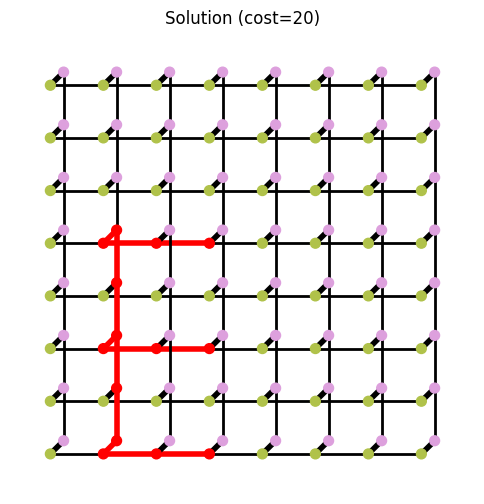

In [5]:
# Routing problem 1
G = create_routing_grid(num_tracks_x=8, num_tracks_y=8)
pins = [
    ('mh', 1, 0, 3, 0),
    ('mh', 1, 4, 3, 4),
    ('mh', 1, 2, 3, 2)
]
terminal_nodes = create_pins_on_grid(G, pins)
draw_grid(G, title='Problem')
Gst, cost = steiner_tree_wrapper(G, terminal_nodes)
draw_grid(G, title=f'Solution ({cost=})')
target = 3*COST_VIA + 4*COST_MV
assert cost == target, f'Cost too high! {target=} {cost=}'

Runtime: 0.002 seconds


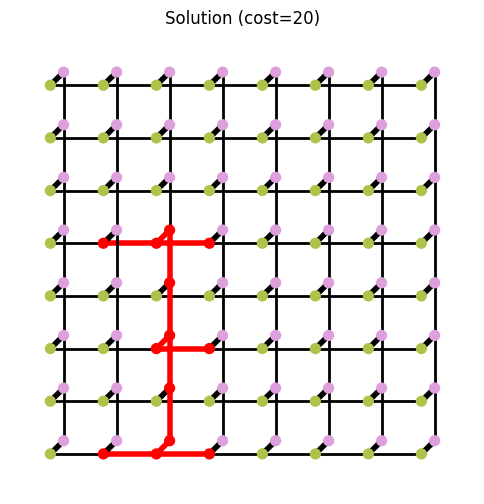

In [6]:
# Routing problem 2
G = create_routing_grid(num_tracks_x=8, num_tracks_y=8)
pins = [
    ('mh', 1, 0, 3, 0),
    ('mh', 1, 4, 3, 4),
    ('mh', 2, 2, 3, 2)
]
terminal_nodes = create_pins_on_grid(G, pins)
# draw_grid(G, title='Problem')
Gst, cost = steiner_tree_wrapper(G, terminal_nodes)
draw_grid(G, title=f'Solution ({cost=})')
target = 3*COST_VIA + 4*COST_MV
assert cost == target, f'Cost too high! {target=} {cost=}'

Runtime: 0.002 seconds


AssertionError: Cost too high! target=28 cost=32

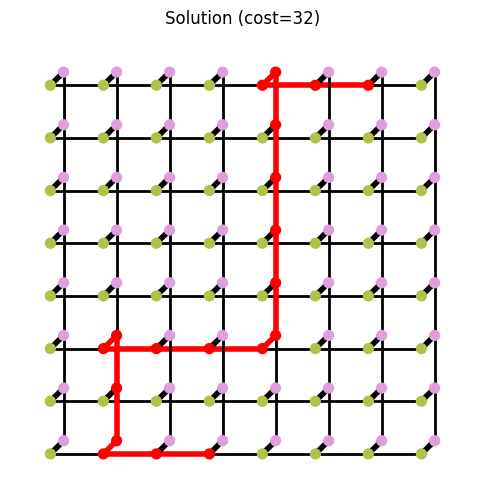

In [7]:
# Routing problem 3
G = create_routing_grid(num_tracks_x=8, num_tracks_y=8)
pins = [
    ('mh', 1, 0, 3, 0),
    ('mh', 1, 2, 3, 2),
    ('mh', 4, 7, 6, 7)
]
terminal_nodes = create_pins_on_grid(G, pins)
# draw_grid(G, title='Problem')
Gst, cost = steiner_tree_wrapper(G, terminal_nodes)
draw_grid(G, title=f'Solution ({cost=})')
target = 7*COST_MV + 1*COST_MH + 3*COST_VIA
assert cost == target, f'Cost too high! {target=} {cost=}'

In [ ]:
# TODO: Only draw the Hanan grid around the pins, not the entire grid
# TODO: Generalize to > 2 layers
# TODO: Implement create_obstructions() for blockages